In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [2]:
batch_size = 256
max_epochs = 100

patience = 10
dropouts = 0.1
weight_decay = 0.001

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=500):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
class NeuralNetwork_dropout(nn.Module):
    def __init__(self, hidden_size = 100, drop_out=0.5):
        super(NeuralNetwork_dropout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(hidden_size, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= size
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    test_correct /= size
    
    return test_loss, test_correct

In [7]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [8]:
model = NeuralNetwork(hidden_size=500)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 33.44%, Train_loss: 0.008304, Test_accuracy: 37.56%, Test_loss: 0.008316
Epoch 2: Train_accuracy: 38.97%, Train_loss: 0.008100, Test_accuracy: 37.78%, Test_loss: 0.008321
Epoch 3: Train_accuracy: 39.84%, Train_loss: 0.008068, Test_accuracy: 36.37%, Test_loss: 0.008386
Epoch 4: Train_accuracy: 40.94%, Train_loss: 0.008027, Test_accuracy: 41.41%, Test_loss: 0.008185
Epoch 5: Train_accuracy: 42.15%, Train_loss: 0.007985, Test_accuracy: 42.03%, Test_loss: 0.008159
Epoch 6: Train_accuracy: 42.29%, Train_loss: 0.007982, Test_accuracy: 41.56%, Test_loss: 0.008189
Epoch 7: Train_accuracy: 41.36%, Train_loss: 0.008020, Test_accuracy: 42.20%, Test_loss: 0.008155
Epoch 8: Train_accuracy: 41.35%, Train_loss: 0.008021, Test_accuracy: 40.20%, Test_loss: 0.008225
Epoch 9: Train_accuracy: 42.16%, Train_loss: 0.007992, Test_accuracy: 39.67%, Test_loss: 0.008261
Epoch 10: Train_accuracy: 40.50%, Train_loss: 0.008058, Test_accuracy: 38.60%, Test_loss: 0.008304
Epoch 11: Train_acc

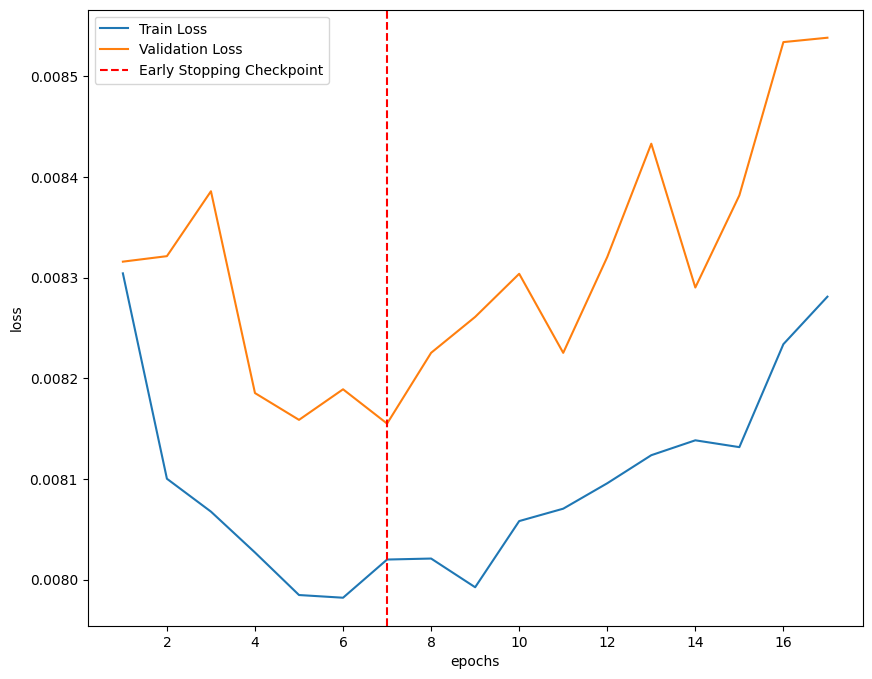

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Train Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
model = NeuralNetwork(hidden_size=500)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr1_loss, tr1_correct = [], []
te1_loss, te1_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr1_loss.append(train_loss), tr1_correct.append(train_correct)
    te1_loss.append(test_loss), te1_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 32.46%, Train_loss: 0.008346, Test_accuracy: 34.18%, Test_loss: 0.008452
Epoch 2: Train_accuracy: 36.94%, Train_loss: 0.008172, Test_accuracy: 38.82%, Test_loss: 0.008275
Epoch 3: Train_accuracy: 38.62%, Train_loss: 0.008113, Test_accuracy: 40.17%, Test_loss: 0.008226
Epoch 4: Train_accuracy: 40.27%, Train_loss: 0.008053, Test_accuracy: 37.37%, Test_loss: 0.008329
Epoch 5: Train_accuracy: 41.76%, Train_loss: 0.007992, Test_accuracy: 42.42%, Test_loss: 0.008155
Epoch 6: Train_accuracy: 43.03%, Train_loss: 0.007947, Test_accuracy: 41.60%, Test_loss: 0.008170
Epoch 7: Train_accuracy: 43.82%, Train_loss: 0.007920, Test_accuracy: 42.74%, Test_loss: 0.008136
Epoch 8: Train_accuracy: 44.68%, Train_loss: 0.007884, Test_accuracy: 43.91%, Test_loss: 0.008071
Epoch 9: Train_accuracy: 45.52%, Train_loss: 0.007856, Test_accuracy: 44.80%, Test_loss: 0.008033
Epoch 10: Train_accuracy: 45.82%, Train_loss: 0.007847, Test_accuracy: 45.42%, Test_loss: 0.008022
Epoch 11: Train_acc

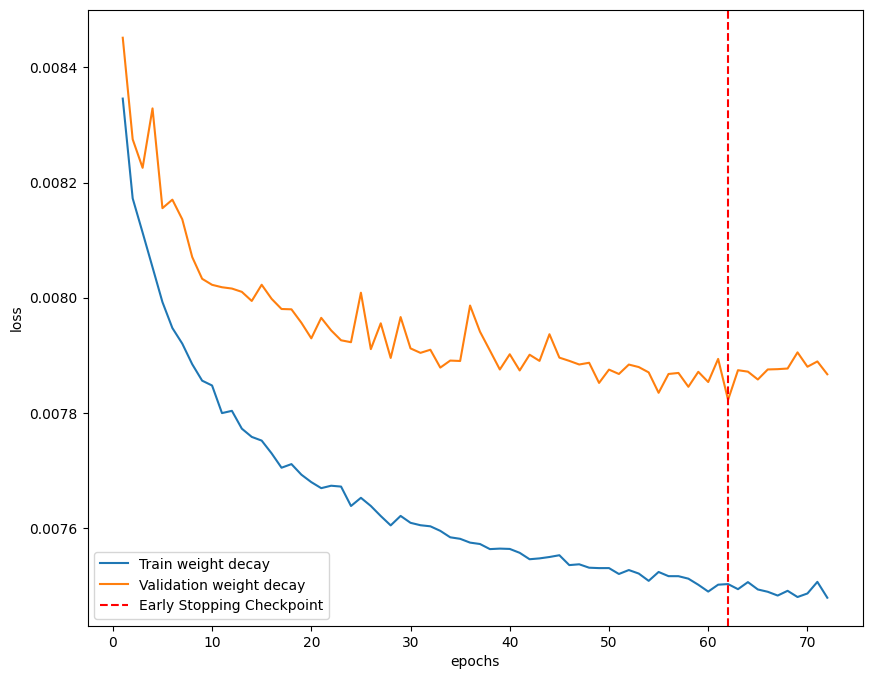

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr1_loss)+1),tr1_loss, label='Train weight decay')
plt.plot(range(1,len(te1_loss)+1),te1_loss,label='Validation weight decay')

# find position of lowest validation loss
minposs = te1_loss.index(min(te1_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
model = NeuralNetwork_dropout(hidden_size=500, drop_out = dropouts)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr2_loss, tr2_correct = [], []
te2_loss, te2_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr2_loss.append(train_loss), tr2_correct.append(train_correct)
    te2_loss.append(test_loss), te2_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 30.92%, Train_loss: 0.008398, Test_accuracy: 34.76%, Test_loss: 0.008445
Epoch 2: Train_accuracy: 36.15%, Train_loss: 0.008211, Test_accuracy: 36.14%, Test_loss: 0.008391
Epoch 3: Train_accuracy: 39.45%, Train_loss: 0.008084, Test_accuracy: 40.81%, Test_loss: 0.008212
Epoch 4: Train_accuracy: 40.14%, Train_loss: 0.008062, Test_accuracy: 38.52%, Test_loss: 0.008320
Epoch 5: Train_accuracy: 40.38%, Train_loss: 0.008053, Test_accuracy: 41.58%, Test_loss: 0.008202
Epoch 6: Train_accuracy: 41.11%, Train_loss: 0.008027, Test_accuracy: 40.87%, Test_loss: 0.008227
Epoch 7: Train_accuracy: 41.07%, Train_loss: 0.008030, Test_accuracy: 40.39%, Test_loss: 0.008245
Epoch 8: Train_accuracy: 41.18%, Train_loss: 0.008028, Test_accuracy: 39.48%, Test_loss: 0.008255
Epoch 9: Train_accuracy: 40.54%, Train_loss: 0.008052, Test_accuracy: 41.02%, Test_loss: 0.008208
Epoch 10: Train_accuracy: 38.88%, Train_loss: 0.008119, Test_accuracy: 37.82%, Test_loss: 0.008335
Epoch 11: Train_acc

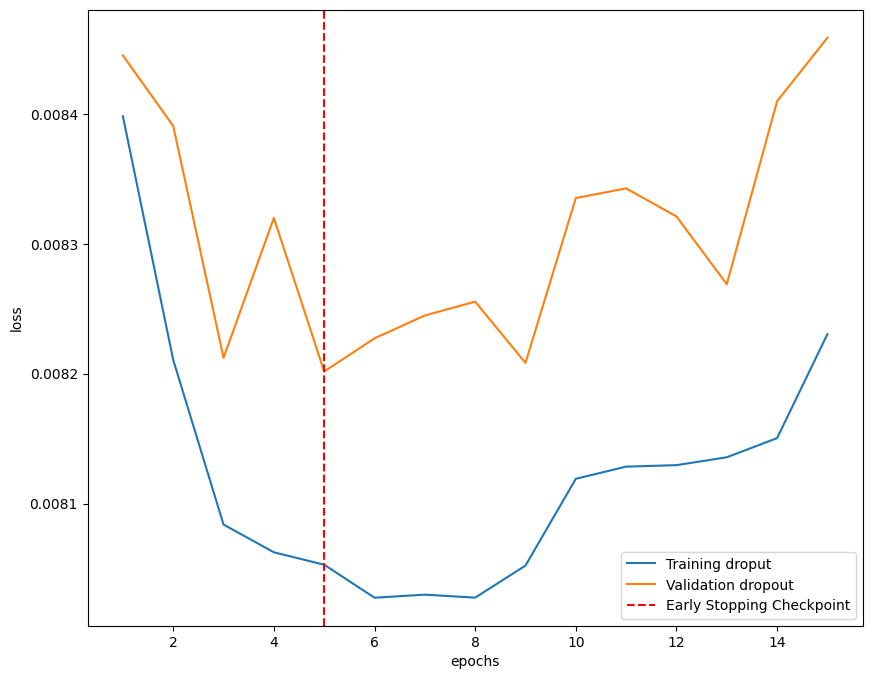

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr2_loss)+1),tr2_loss, label='Training droput')
plt.plot(range(1,len(te2_loss)+1),te2_loss,label='Validation dropout')

# find position of lowest validation loss
minposs = te2_loss.index(min(te2_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
model = NeuralNetwork_dropout(hidden_size=500, drop_out = dropouts)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr3_loss, tr3_correct = [], []
te3_loss, te3_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr3_loss.append(train_loss), tr3_correct.append(train_correct)
    te3_loss.append(test_loss), te3_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 32.28%, Train_loss: 0.008346, Test_accuracy: 37.09%, Test_loss: 0.008356
Epoch 2: Train_accuracy: 36.54%, Train_loss: 0.008190, Test_accuracy: 38.68%, Test_loss: 0.008272
Epoch 3: Train_accuracy: 38.96%, Train_loss: 0.008097, Test_accuracy: 37.49%, Test_loss: 0.008311
Epoch 4: Train_accuracy: 40.03%, Train_loss: 0.008061, Test_accuracy: 40.78%, Test_loss: 0.008204
Epoch 5: Train_accuracy: 40.67%, Train_loss: 0.008028, Test_accuracy: 38.93%, Test_loss: 0.008262
Epoch 6: Train_accuracy: 41.88%, Train_loss: 0.007992, Test_accuracy: 41.56%, Test_loss: 0.008164
Epoch 7: Train_accuracy: 42.12%, Train_loss: 0.007979, Test_accuracy: 41.32%, Test_loss: 0.008177
Epoch 8: Train_accuracy: 42.53%, Train_loss: 0.007966, Test_accuracy: 42.95%, Test_loss: 0.008123
Epoch 9: Train_accuracy: 42.84%, Train_loss: 0.007953, Test_accuracy: 42.17%, Test_loss: 0.008152
Epoch 10: Train_accuracy: 43.51%, Train_loss: 0.007927, Test_accuracy: 42.40%, Test_loss: 0.008139
Epoch 11: Train_acc

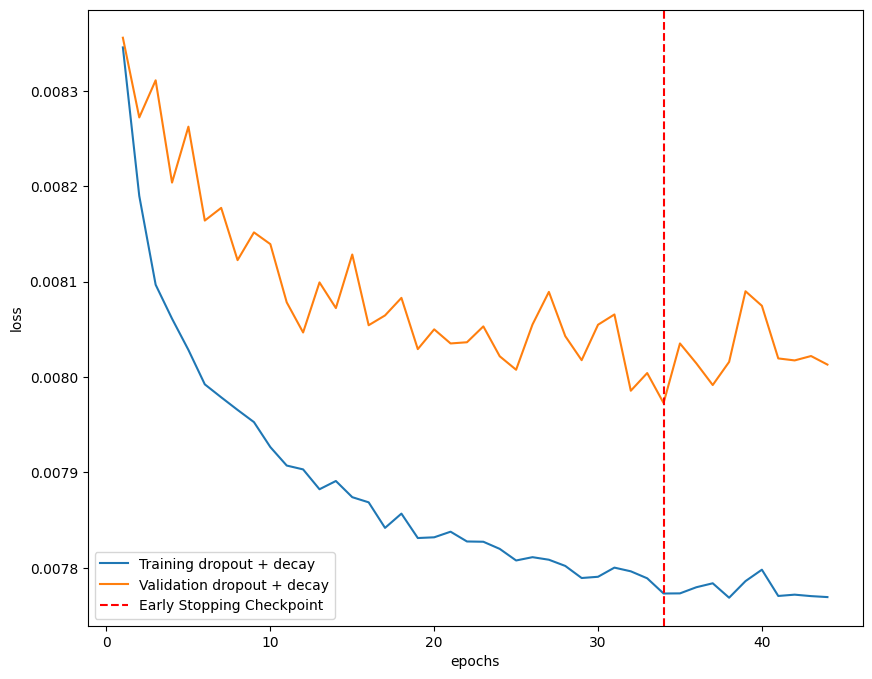

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr3_loss)+1),tr3_loss, label='Training dropout + decay')
plt.plot(range(1,len(te3_loss)+1),te3_loss,label='Validation dropout + decay')

# find position of lowest validation loss
minposs = te3_loss.index(min(te3_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

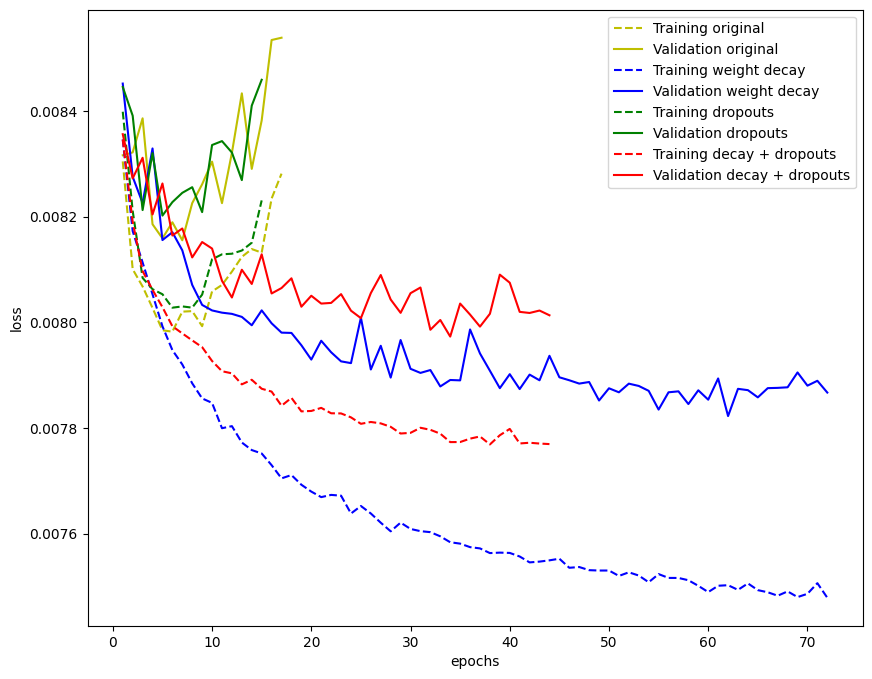

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, linestyle = '--', color = 'y', label='Training original')
plt.plot(range(1,len(te_loss)+1),te_loss, color = 'y', label='Validation original')
plt.plot(range(1,len(tr1_loss)+1),tr1_loss, linestyle = '--', color = 'b', label='Training weight decay')
plt.plot(range(1,len(te1_loss)+1),te1_loss, color = 'b', label='Validation weight decay')
plt.plot(range(1,len(tr2_loss)+1),tr2_loss, linestyle = '--', color = 'g', label='Training dropouts')
plt.plot(range(1,len(te2_loss)+1),te2_loss, color = 'g', label='Validation dropouts')
plt.plot(range(1,len(tr3_loss)+1),tr3_loss, linestyle = '--', color = 'r', label='Training decay + dropouts')
plt.plot(range(1,len(te3_loss)+1),te3_loss, color = 'r', label='Validation decay + dropouts')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()